In [1]:
from collect_data import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import mne
from mne.datasets import sample
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)

import pickle


In [2]:
subject="01"
session="0"
task="0"

load=True
if not load:

    epochs_list = []
    for session in ["0"]:
        for task in [0, 1, 2, 3]:
            bids_path = mne_bids.BIDSPath(
                subject=subject,
                session=str(session),
                task=str(task),
                datatype="meg",
                root="/home/matteo/data/MEG",
            )
            try:
                raw = mne_bids.read_raw_bids(bids_path)
            except FileNotFoundError:
                print("missing", subject, session, task)
                pass
            raw = raw.pick_types(
                meg=True, misc=False, eeg=False, eog=False, ecg=False
            )

            raw.load_data().filter(0.5, 30.0, n_jobs=1)

            meta = list()
            for annot in raw.annotations:
                d = eval(annot.pop("description"))
                for k, v in annot.items():
                    assert k not in d.keys()
                    d[k] = v
                meta.append(d)
            meta = pd.DataFrame(meta)
            meta["intercept"] = 1.0


            meta=meta[meta["kind"]=="word"]    

            # segment
            events = np.c_[
                meta.onset * raw.info["sfreq"], np.ones((len(meta), 2))
            ].astype(int)
            

            epochs = mne.Epochs(
            raw,
            events,
            tmin=-0.200,
            tmax=0.5,
            decim=10,
            baseline=(-0.2, 0.0),
            metadata=meta,
            preload=True,
            event_repeated="drop",
        )

            # threshold
            th = np.percentile(np.abs(epochs._data), 95)
            epochs._data[:] = np.clip(epochs._data, -th, th)
            epochs.apply_baseline()
            th = np.percentile(np.abs(epochs._data), 5)
            epochs._data[:] = np.clip(epochs._data, -th, th)
            epochs.apply_baseline()

            epochs_list.append(epochs)
    with open(meg_path+'/epochs_list_subj01.pkl', 'wb') as f:
        pickle.dump(epochs_list, f)
else:

    with open(meg_path+'/epochs_list_subj01.pkl', 'rb') as f:
        epochs_list = pickle.load(f)


In [3]:
#concate epochs

concatenated_epochs = mne.concatenate_epochs(epochs_list)
concatenated_epochs

#save everything using pickle


/tmp/ipykernel_1429180/3376065280.py:3: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Adding metadata with 18 columns
8561 matching events found
Applying baseline correction (mode: mean)


Number of events,8561
Events,1: 8561
Time range,-0.200 – 0.500 s
Baseline,-0.200 – 0.000 s


In [7]:
concatenated_epochs[-1]._metadata

,story,story_uid,sound_id,kind,start,sound,onset,duration,orig_time,phoneme,sequence_id,condition,word_index,speech_rate,voice,pronounced,word,intercept
8560,The_Black_Willow,3.0,11.0,word,117.95,stimuli/audio/The_Black_Willow_11.wav,1853.387,0.23,2000-01-01 00:00:00+00:00,NaN,252.0,sentence,65.0,205.0,Ava,1.0,them,1.0


In [8]:
#now for each epoch get the data and label, using the voice as label

X=concatenated_epochs.get_data()
y=concatenated_epochs._metadata.voice

#split the train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [14]:
#encode the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train=le.transform(y_train)
y_test=le.transform(y_test)


In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5992, 208, 71), (2569, 208, 71), (5992,), (2569,))

(array([3066.,    0.,    0.,    0.,    0., 1299.,    0.,    0.,    0.,
        1627.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

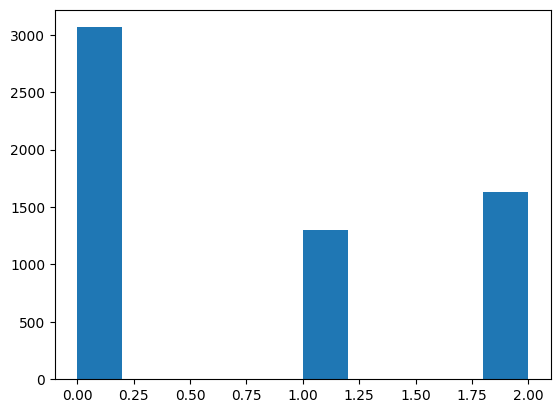

In [7]:
plt.hist(y_train)

In [20]:
clf = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear",C=0.1,class_weight="balanced"))

time_decod = SlidingEstimator(clf, n_jobs=-1, scoring="accuracy", verbose=True)
# here we use cv=3 just for speed

time_decod.fit(X_train, y_train)
# scores = cross_val_multiscore(time_decod, X, y, cv=3, n_jobs=None)


100%|██████████| Fitting SlidingEstimator : 71/71 [00:05<00:00,   12.32it/s]


<SlidingEstimator({'allow_2d': False,
 'base_estimator': Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    solver='liblinear'))]),
 'n_jobs': -1,
 'position': 0,
 'scoring': 'accuracy',
 'verbose': True}, fitted with 71 estimators>

In [21]:
y_pred=time_decod.predict(X_test)

100%|██████████| Transforming SlidingEstimator : 71/71 [00:02<00:00,   30.78it/s]


In [22]:
#compute accuracy for each time point
from sklearn.metrics import accuracy_score
acc=[]
kp=[]
for i in range(y_pred.shape[-1]):
    acc.append(accuracy_score(y_test, y_pred[:,i]))
    kp.append(cohen_kappa_score(y_test, y_pred[:,i]))


In [30]:


from sklearn.metrics import classification_report


print(classification_report(y_test, y_pred[:,0]))

              precision    recall  f1-score   support

           0       0.52      0.60      0.56      1346
           1       0.22      0.16      0.19       579
           2       0.25      0.22      0.23       644

    accuracy                           0.41      2569
   macro avg       0.33      0.33      0.33      2569
weighted avg       0.38      0.41      0.39      2569



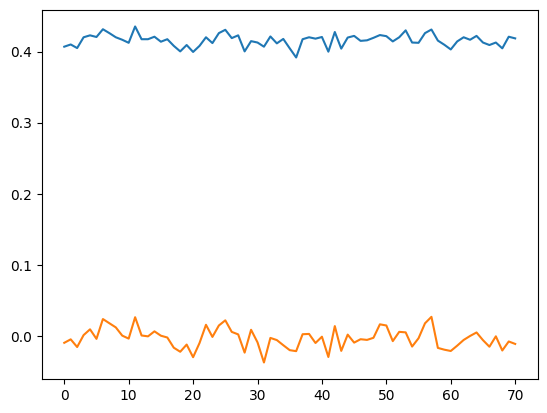

In [23]:
plt.plot(acc)
plt.plot(kp)

In [ ]:
plt.hist(y_train)

In [41]:
clf = make_pipeline(
    Scaler(concatenated_epochs.info),
    Vectorizer(),
    LogisticRegression(solver="liblinear"),  # liblinear is faster than lbfgs
)

clf.fit(X_train, y_train)

Pipeline(steps=[('scaler',
                 Scaler({'info': {'acq_pars': None,
          'acq_stim': None,
          'bads': [],
          'ch_names': ['MEG 001',
                       'MEG 002',
                       'MEG 003',
                       'MEG 004',
                       'MEG 005',
                       'MEG 006',
                       'MEG 007',
                       'MEG 008',
                       'MEG 009',
                       'MEG 010',
                       'MEG 011',
                       'MEG 012',
                       'MEG 013',
                       'MEG 014',
                       'MEG 015',
                       'MEG 016',
                       'MEG 017',
                       'MEG 018',
                       'MEG 019',
                       'MEG 020',
                       'MEG 021',
                       'MEG 022',
                       'MEG 023',
                       'MEG 024',
                       'MEG 025',
                       'MEG 026',
                       'MEG 027',
                       'MEG 028',
                       'M...
                           'his_id': 'sub-01',
                           'mri': 'fsaverage',
                           'n_sessions': '2',
                           'native_english_speaker': 'y',
                           'sex': 1,
                           'task_order': '"[0, 1, 2, 3]"'},
          'utc_offset': None,
          'xplotter_layout': None},
 'scalings': None,
 'with_mean': True,
 'with_std': True})),
                ('vectorizer',
                 <mne.decoding.transformer.Vectorizer object at 0x7fc2d665b730>),
                ('logisticregression', LogisticRegression(solver='liblinear'))])